<img src="../code/Resources/cropped-SummerWorkshop_Header.png"> 

<h1 align="center">Workshop 2: Behavioral state identification </h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h3 align="center">Thursday, August 28th, 2025</h3> 
<h4 align="center">Day 4</h4> 

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> During the morning lecture, we learned about behavioral states and how they affect the processing of sensory stimuli and shape actions. In this workshop, we will explore how to define behavioral states using computational methods. We'll explore the Visual Behavior Neuropixels dataset as an example case. We'll first use data visualization to gain an intuition for task-engaged versus task disengaged behavioral states in this dataset. Next, we'll learn about Hidden Markov Models and use them to identify behavioral states in an unsupervised manner. 

</div>

In [1]:
# Standard library
import os  

# Data handling packages
import numpy as np  
import numpy.random as npr  
import pandas as pd 
import pynwb  
import random

# Progress bar utility
from tqdm import tqdm  # Displays a smart progress bar during loops

# Preprocessing
from sklearn.preprocessing import StandardScaler  # Standardizes features (zero mean, unit variance)

# Plotting libraries
import matplotlib.pyplot as plt  
from matplotlib import colors  
import seaborn as sns  

# Pandas display settings
pd.set_option('display.max_columns', None)  # Ensures all columns are shown when printing DataFrames

# Inline plotting for Jupyter Notebooks
%matplotlib inline  


# Load Visual Behavior experiment from NWB

 <div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">   
<p> To begin, let's start by reacquainting ourselves with the Visual Behavior dataset from Workshop 1. However, this time we will explore their behavioral patterns.
</div>

In [2]:
# Example sessions we'll use in this tutorial
example_session_ids = [1139846596, 1152811536]

session_id = example_session_ids[0] # Let's look at the first example session
nwb_path = f'/root/capsule/data/visual-behavior-neuropixels/behavior_ecephys_sessions/{session_id}/ecephys_session_{session_id}.nwb'

# access the session data with pynwb
session = pynwb.NWBHDF5IO(nwb_path).read()

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [3]:
# Quick reference of the NWB file structure
# Important groups include: units, trials, intervals, and processing 

session

Data type,float64
Shape,"(569455, 2)"
Array size,8.69 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(569455,)"
Array size,4.34 MiB
Chunk shape,None


In [4]:
# Get trials dataframe and look at a few rows
trials = session.trials[:]
display(trials.tail(7))

,start_time,stop_time,initial_image_name,change_image_name,is_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
id,,,,,,,,,,,,,,,,,,,,
666,3569.02072,3577.04436,im034_r,im111_r,True,3572.77425,True,False,[],NaN,NaN,0.0,False,False,True,False,False,False,212586,8.02364
667,3577.27756,3584.55068,im111_r,im005_r,True,3580.28058,True,False,[],NaN,NaN,0.0,False,False,True,False,False,False,213036,7.27312
668,3584.78386,3595.05972,im005_r,im114_r,True,3590.78936,True,False,[],NaN,NaN,0.0,False,False,True,False,False,False,213666,10.27586
669,3595.29274,3603.33308,im114_r,im087_r,True,3599.06298,True,False,[],NaN,NaN,0.0,False,False,True,False,False,False,214162,8.04034
670,3603.56657,3613.09114,im087_r,im083_r,True,3608.82129,True,False,[],NaN,NaN,0.0,False,False,True,False,False,False,214747,9.52457
671,3613.32445,3620.59745,im083_r,im104_r,True,3616.32739,True,False,[],NaN,NaN,0.0,False,False,True,False,False,False,215197,7.27300
672,3620.83080,3633.34224,im104_r,im114_r,True,3629.08844,True,False,[],NaN,NaN,0.0,False,False,True,False,False,False,215962,12.51144


# Mouse behavioral performance over the session

<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
How well does the mouse identify image changes? We can quantify their performance by evaluating the fraction of 'go' trials during which the mouse licked the spout ('hit' trials).      
</div>

In [5]:
num_go_trials = len(np.where(trials.go)[0])
num_go_hit_trials = len(np.where(trials.go[trials.hit])[0])
print('Proportion of trials correctly performed: ' + str(np.round(num_go_hit_trials/num_go_trials, 2)))

Proportion of trials correctly performed: 0.46


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 2.1:</b>  Examine the 2nd example mouse. Print the proportion of 'go' trials that the mouse performed correctly and evaluate their mean performance. (Note: session = get_session(session_id) will take a minute or two to load the session))
</div>

<div style="background:rgb(240, 230, 216); border-radius: 3px; padding: 10px;">
Note: Please be wary while naming variables. Do not use variable names that are already assigned. Preferably, append the number corresponding to the example you are analyzing as we have done below. For example, if analyzing example mouse 2, use num_go_trials_2. 

In [6]:
# Blank coding cell to work out Task 2.1  

# Here, we have included the code to load the data from the other example mice.
session_id_2 = example_session_ids[1]
nwb_path_2 = f'/root/capsule/data/visual-behavior-neuropixels/behavior_ecephys_sessions/{session_id_2}/ecephys_session_{session_id_2}.nwb'
session_2 = pynwb.NWBHDF5IO(nwb_path_2).read()
trials_2 = session_2.trials[:]


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [7]:
num_go_trials_2 = len(np.where(trials_2.go)[0])
num_go_hit_trials_2 = len(np.where(trials_2.go[trials_2.hit])[0])
print('Proportion of trials correctly performed: ' + str(np.round(num_go_hit_trials_2/num_go_trials_2, 2)))

Proportion of trials correctly performed: 0.63


<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Looks like these mice fail to respond in about 40-50% of the trials!

<p> Next, we will plot licking patterns for each 'go' trial to get a sense of when the mouse fails to respond.
</div>

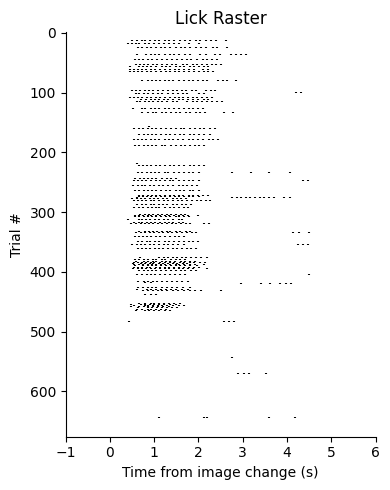

In [8]:
# Select 'go' trials from trials table
go_trials = trials[trials.go]

# Get lick times for each 'go' trial. Note: we subtract the time of the image change
lick_times = go_trials.lick_times.values - go_trials.change_time_no_display_delay.values

# Plot with eventplot
fig, ax = plt.subplots(figsize=(4, 5))
ax.eventplot(lick_times, orientation='horizontal', colors='black', linelengths=1, lineoffsets = go_trials.index)

# formatting 
ax.set_xlabel('Time from image change (s)')
ax.set_ylabel('Trial #')
ax.set_title('Lick Raster')
ax.set_ylim(-1, go_trials.index[-1]+4)
ax.set_xlim(-1, 6)
plt.gca().invert_yaxis()  # Trial 0 at top
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()


<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Interestingly, this mouse licks on many trials during the first part of the session but then rarely licks during the later trials.
</div>

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 2.2:</b> Plot lick rasters for the other example mouse. Does this mouse show a trend in licking behavior over the session?
</div>

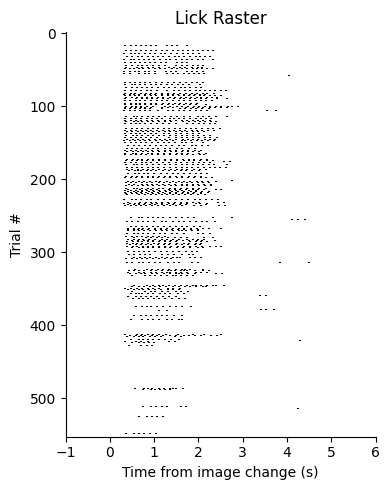

In [9]:
# Blank coding cell to work out Task 2.2  
# hint: use "trials_2" 

# Get 'go'trial numbers
go_trials_2 = trials_2[trials_2.go]

# Get lick times for each 'go' trial. Note: we subtract the trial start time so lick times are relative to trial start
lick_times_2 = go_trials_2.lick_times.values - go_trials_2.change_time_no_display_delay.values

# Plot with eventplot
fig, ax = plt.subplots(figsize=(4, 5))
ax.eventplot(lick_times_2, orientation='horizontal', colors='black', linelengths=1, lineoffsets = go_trials_2.index)

# formatting 
ax.set_xlabel('Time from image change (s)')
ax.set_ylabel('Trial #')
ax.set_title('Lick Raster')
ax.set_ylim(-1, go_trials_2.index[-1]+4)
ax.set_xlim(-1, 6)
plt.gca().invert_yaxis()  # Trial 0 at top
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> So, these mice seem to stop responding during the later trials in the session. Another way of looking at this data is to quantify the number of licks in each trial. 
</div>

# Identifying task-engagement states based on visual inspection

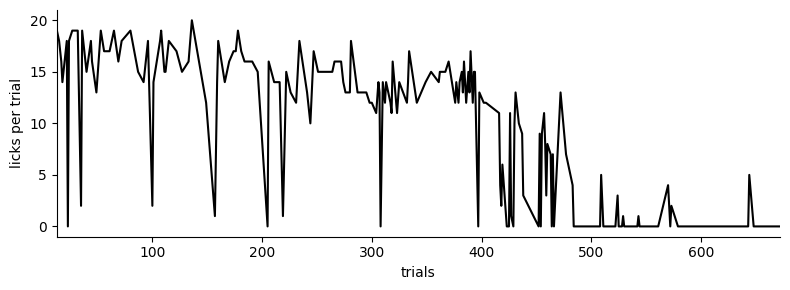

In [10]:
# Predefine figure
fig, ax = plt.subplots(figsize = (8, 3))

# Get lick counts for each go trial
lick_count = go_trials.apply(lambda row : len(row['lick_times']), axis = 1)

# Plot lick count
ax.plot(lick_count, color='k', lw = 1.5)

# Formatting
ax.set_ylabel('licks per trial')
ax.set_xlabel('trials')
ax.set_xlim(go_trials.index[0], go_trials.index[-1])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Could the mouse be disengaging from the task as they reach the end of the session? The reduction in licking seems to indicate this. 
<p> We can quantify their performance by computing the hit rate over the behavioral session. Hit rate is the probability the mouse correctly performs a lick during 'go' trials. Here, we will evaluate this as the fraction over 10 go-trials.
    
</div>

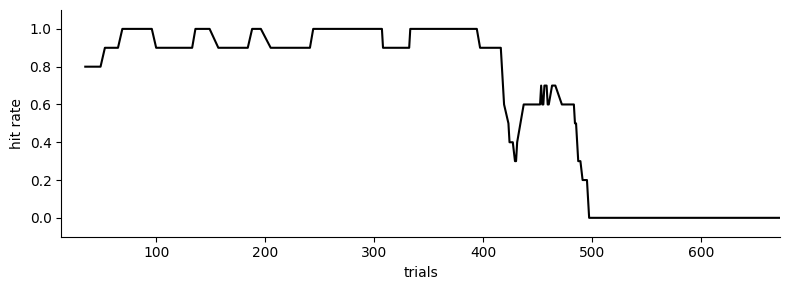

In [11]:
# Compute hit rate with 10 trial rolling window.
hit_rate = go_trials.hit.rolling(10).mean()

fig,ax = plt.subplots(figsize = (8, 3)) 
ax.plot(go_trials.index, hit_rate, color = 'k', lw = 1.5)

# Formatting
ax.set_xlim(go_trials.index[0], go_trials.index[-1])
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('trials')
ax.set_ylabel('hit rate')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> We see that the hit rate is very high during the first 400 trials, then drops to zero around trial 500. Thus, the mouse is clearly "task engaged" during the first part of the session, but then becomes "task disengaged". Using this insight we can set an  threshold on hit rate to define engaged and disengaged states. What's a good threshold to set? 
</div>

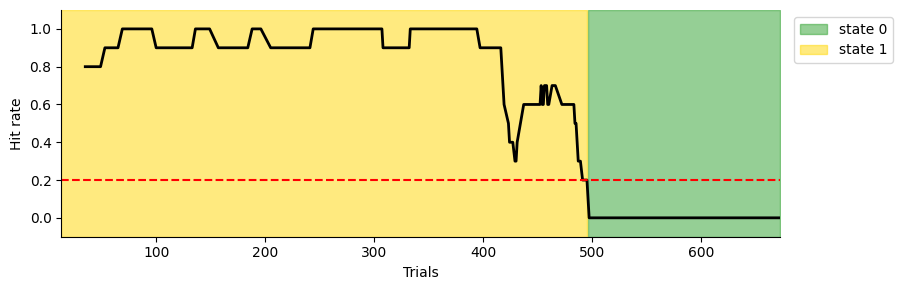

In [12]:
# Threshold for defining engageded vs disengaged states
engagement_threshold = 0.2

fig,ax = plt.subplots(figsize = (8, 3)) 
ax.plot(go_trials.index, hit_rate, color = 'k', lw = 2)
ax.plot(go_trials.index, engagement_threshold*np.ones(num_go_trials), color = 'r', ls = '--')

# Determine state transition boundaries
states = hit_rate < engagement_threshold
ax.fill_between(states.index, -0.1, 1.1, where = states == 1, alpha=0.5, color = 'tab:green', label = 'state 0')
ax.fill_between(states.index, -0.1, 1.1, where = states == 0, alpha=0.5, color = 'gold', label = 'state 1')

# Formatting
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(go_trials.index[0], go_trials.index[-1])
ax.set_xlabel('Trials')
ax.set_ylabel('Hit rate')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1))
plt.tight_layout()

# Do running speed and pupil size vary with task-engagement?

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> When the mouse’s task-engagement state changes, does it affect other aspects of its behavior too? To answer this, let’s look beyond their lick patterns and examine additional variables including running speed and pupil size. </p>

</div>

In [13]:
# Get timestamps corresponding to go trials
trial_start = go_trials.start_time
trial_stop = go_trials.stop_time

# initialize data dictionary
behavior_data = {}

In [14]:
# Get running speed and corresponding timestamps
running_data = session.processing['running']
running_timestamps = running_data['speed'].timestamps[:]
running_speed = running_data['speed'].data[:]
running_speed = pd.Series(running_speed).interpolate(limit_direction='both').to_numpy() 
behavior_data['running_speed']  = [np.nanmean(running_speed[np.logical_and(s1 <= running_timestamps, running_timestamps <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

In [15]:
# Get pupil area and corresponding timestamps
pupil_data = session.acquisition['EyeTracking']['pupil_tracking']
pupil_timestamps = pupil_data.timestamps[:]
pupil_area = pupil_data.area[:]
pupil_area = pd.Series(pupil_area).interpolate(limit_direction='both').to_numpy() 
behavior_data['pupil_area'] = [np.nanmean(pupil_area[np.logical_and(s1 <= pupil_timestamps, pupil_timestamps <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

In [16]:
# Add lick count data to behavior_data dictionary
behavior_data['lick_count'] = lick_count 

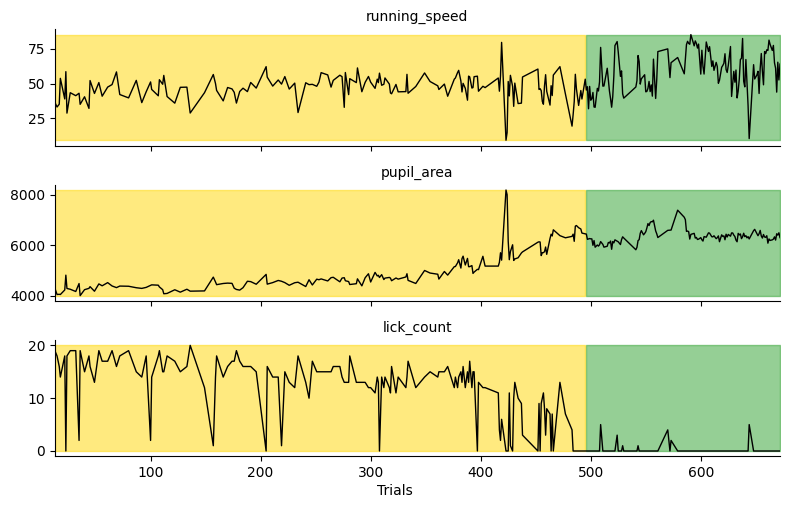

In [17]:
keys_to_plot = ['running_speed', 'pupil_area','lick_count']

fig, ax = plt.subplots(len(keys_to_plot), 1, figsize = (8, 5), sharex = True)

for i, key in enumerate(keys_to_plot):
    ax[i].plot(go_trials.index, behavior_data[key], color = 'k', lw = 1)
    ax[i].set_title(key, fontsize = 10)
    
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)

    # Get min and max of this behavior trace
    min_val = np.nanmin(behavior_data[key])
    max_val = np.nanmax(behavior_data[key])

    # Fill between min*vis_context and max*vis_context
    ax[i].fill_between(states.index, min_val, max_val, where = states == 1, alpha=0.5, color = 'tab:green')
    ax[i].fill_between(states.index, min_val, max_val, where = states == 0, alpha=0.5, color = 'gold')

    ax[i].set_xlim(go_trials.index[0], go_trials.index[-1])

fig.text(0.5, 0.00, 'Trials', ha='center')
plt.tight_layout()


<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> While defining behavioral states by thresholding the hit rate is a useful starting point, it is incomplete. There are several additional variables that could provide more nuanced insights into the mouse’s behavioral states but we have not incorporated these into our definition of behavioral states. </p>

<p>Moreover, the threshold we used to define behavioral states appeared appropriate for the mouse we studied but may not generalize across animals. How, then, can we systematically assess state changes across many mice?</p>

<p>In the remainder of this workshop, we will explore more sophisticated methods for defining behavioral states that integrate multiple features to provide a richer, more reliable description of each mouse’s behavioral profile.</p>
</div>


# Examine pairwise correlations between behavioral features

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> First, we'll learn how to make sense of a more complex view of the behavioral information. Instead of looking at just one behavioral variable, we will examine multiple variables simultaneously to gain a better understanding of what's going on. As we have seen, some of these behavior variables correlate with the task-engaged behavioral state and also correlate with each other. Let's create a visualization to see how the different behavioral variables are correlated.

</div>

In [18]:
# Convert behavior_data dictionary to dataframe for ease of use 
behavior_df = pd.DataFrame(behavior_data)
behavior_df.head(7)

,running_speed,pupil_area,lick_count
id,,,
13,36.486412,4292.583735,19
15,33.135666,4041.700482,18
17,35.149516,4049.560114,16
18,53.751427,4039.805348,14
22,38.937263,4220.875109,18
23,58.562790,4808.644579,0
24,28.738495,4280.066217,18


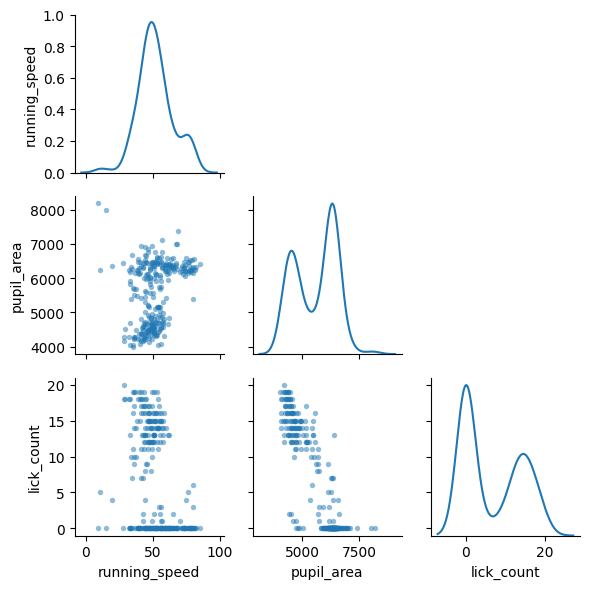

In [19]:
# Set layout for pairwise plot - 3 X 3 plot grid
g = sns.PairGrid(behavior_df,  vars=['running_speed', 'pupil_area', 'lick_count'], diag_sharey=False)

# Plot 2D density plot in the lower triangle 
g.map_lower(sns.scatterplot, s=15, alpha=0.5, linewidth=0)

# Hide the upper triangle 
def hide_current_axis(*args, **kwds):
    # function to hide upper triangle of the pairwise plots
    plt.gca().set_visible(False)
g.map_upper(hide_current_axis)

# Plot 1D density plot
g.map_diag(sns.kdeplot, hue=None, legend=False, bw_method = 'scott')

# Formatting 
g.fig.set_size_inches(6,6)
g.fig.tight_layout()

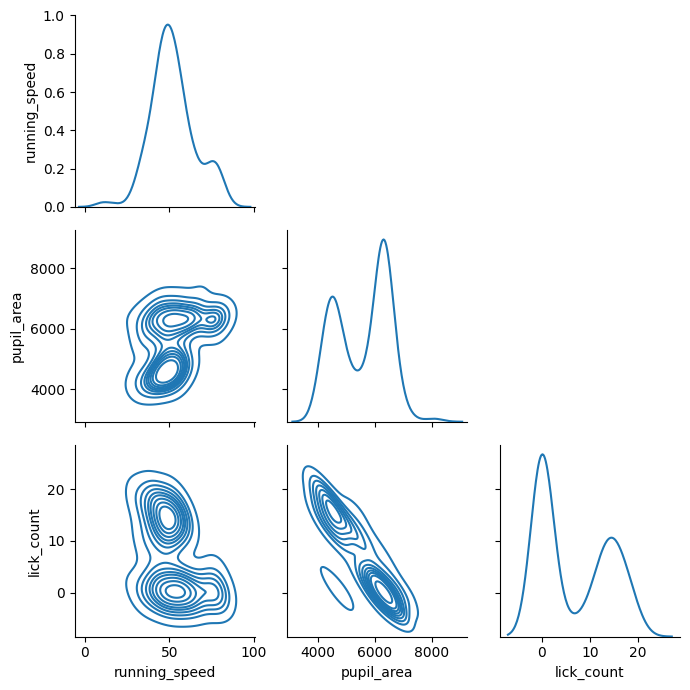

In [20]:
# Set layout for pairwise plot - 3 X 3 plot grid
g = sns.PairGrid(behavior_df,  vars=['running_speed', 'pupil_area', 'lick_count'], diag_sharey=False)

# Plot 2D density plot in the lower triangle 
width = 'scott' # "Scott Method" for choosing width of density kernel
g.map_lower(sns.kdeplot, hue=None, bw_method = width)

# Hide the upper triangle 
def hide_current_axis(*args, **kwds):
    # function to hide upper triangle of the pairwise plots
    plt.gca().set_visible(False)
g.map_upper(hide_current_axis)

# Plot 1D density plot
g.map_diag(sns.kdeplot, hue=None, legend=False, bw_method = width)

# Formatting 
g.fig.set_size_inches(7,7)
g.fig.tight_layout()

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 2.3: </b> In the pairwise density plots, try playing around with the option 'bw_method' by setting it to scalar values between [0.2, 1]. How does this affect the density plots? Do you still think there are only 2 states? Do this below. 
</div>

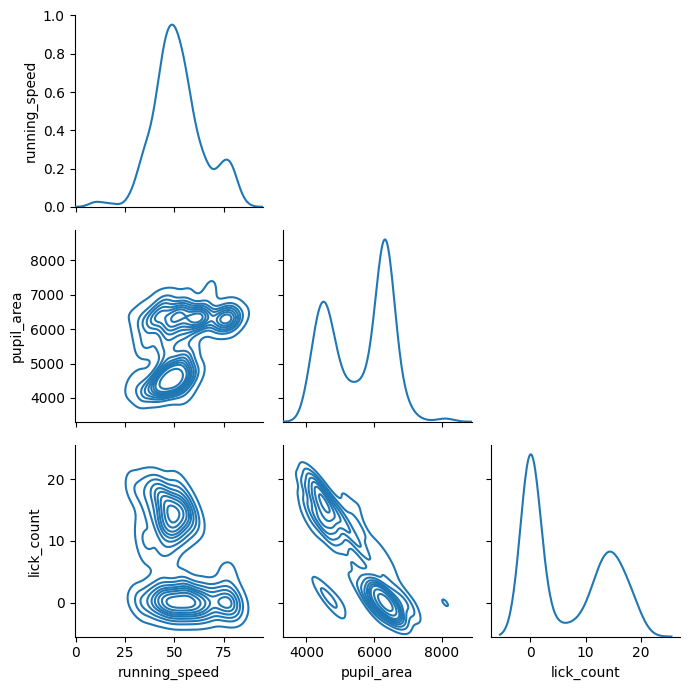

In [21]:
# Set layout for pairwise plot - 3 X 3 plot grid
g = sns.PairGrid(behavior_df,  vars=['running_speed', 'pupil_area', 'lick_count'], diag_sharey=False)

# Plot 2D density plot in the lower triangle 
width = .25 # Explore range between 0.2 and 1

g.map_lower(sns.kdeplot, hue=None, bw_method = width)

# Hide the upper triangle 
def hide_current_axis(*args, **kwds):
    # function to hide upper triangle of the pairwise plots
    plt.gca().set_visible(False)
g.map_upper(hide_current_axis)

# Plot 1D density plot
g.map_diag(sns.kdeplot, hue=None, legend=False, bw_method = width)

# Formatting 
g.fig.set_size_inches(7,7)
g.fig.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> This visualization broadly showed two states that mapped well to our previous state definitions. But playing around with the density plots may have raised some doubts. </p>
    
<p> Does every peak deserve a behavior state? How can we define state boundaries while incorporating all behavior variables? Are there other behavior states? </p>

<p> Moreover, when determining behavioral states, we are dealing with data that changes over time, where the current state may depend on the current observation and also on the previous state. How do we incorporate time information?! </p>
    
</div>

# !! Michael Buice Whiteboard Session !!

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>Multivariate definition of behavioral states</h4>

<p>The density plots suggest there may be multiple underlying behavioral states. One approach to identifying these states is to use unsupervised clustering methods to group similar observations across multiple behavioral variables, revealing distinct patterns that may correspond to different states.</p>

<p>K-means and Gaussian Mixture Models (GMMs) are two such clustering methods. While K-means assigns each data point to a single cluster with a deterministic assignment, GMMs allow data points to belong to multiple clusters with varying degrees of membership probabilities, making them more flexible than K-means. Unlike K-means, GMMs can model clusters with different shapes and orientations, providing a more realistic representation of the underlying structure.</p>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> K-means and Gaussian Mixture Models</h3>
    
<p> First, lets sort out our notation: 
<br> <b> Constants</b> 
    <ul>
        <li>$N$ - number of data points. </li>
        <li>$K$ - number of clusters/components </li>
    </ul>

<b> Data</b> 
    <ul>
        <li> $\mathbf{X} = \{x_{n}\}_{n=1}^N$ where $x_n \in \mathbb{R}^{D}$ is the $n^{th}$ data point </li>
    </ul>
    
<b> Latent Variables </b> 
    <ul>
        <li>$\mathbf{Z} = \{z_{n}\}_{n=1}^N$ wher $z_n \in \{1, ..., K\}$ is the cluster assignment for the $n^{th}$ data point </li>
    </ul>
    
<b> Parameters</b>   
    <ul> 
        <li> $\boldsymbol{\Theta} = \{\mu_k\}_{k=1}^K$ where $\mu_k \in \mathbb{R}^D$ is the mean of the $k$-th cluster </li>
    </ul>
    
<h4>K-Means</h4>
    K-Means is an algorithm for estimating the latent variables, $\mathbf{Z}$, and the parameters, $\boldsymbol{\Theta}$, given the data, $\mathbf{X}$. The algorithm alternates between two steps,
    <ol>
        <li><b>Assign</b> each data point to the closest cluster:
            \begin{align}
            z_{n} = \underset{k \in \{1,..., K\}}{\text{arg min}} || x_{n} - \mu_{k}||_{2}
            \end{align}
        </li>
        <li><b>Update</b> the parameters to the mean of the assigned data points
            \begin{align}
            \mu_{k} = \frac{1}{N_{k}}\sum_{n = 1}^{K} w_{n,k} x_{n}, 
            \end{align}
            where 
            \begin{align}
            w_{n,k} &= \begin{cases} 1 & \text{if } z_n =k \\ 0 & \text{o/w} \end{cases} \\
            N_k &= \sum_{n=1}^{N} w_{n,k}.
            \end{align}
        </li>
    </ol>
    

We can think of $w_{n,k}$ as the <i>weight</i> or <i>responsibility</i> that data point $n$ assigns to cluster $k$. 
<br>
</div>

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Question:</b> From this perspective, isn't it weird that K-Means assigns all the weight to the nearest cluster, even for points that are right on the boundary between two clusters? 
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>Expectation-Maximization (EM)</h4>
Instead, consider the following tweak to K-Means. Instead of setting the weight to 0 or 1, set it to,
\begin{align}
    w_{n,k} &= \frac{\mathcal{N}(x_n \mid \mu_k, I)}{\sum_{j=1}^K \mathcal{N}(x_n \mid \mu_j, I)}
\end{align}
where $\mathcal{N}(x \mid \mu, \Sigma)$ denotes the <b>probability density function (pdf)</b> of a point $x_n$ under a <b>multivariate normal distribution</b> with mean $\mu$ and covariance $\Sigma$.
<br>
Then the resulting algorithm corresponds to the expectation-maximization (EM) algorithm. EM is a generic algorithm of estimating the parameters of latent variable models. In this case, it estimates the parameters $\boldsymbol{\Theta}$ of a Gaussian mixture model.


<h4>Gaussian Mixture Model (GMM)</h4>
A GMM is a probabilistic model that specifies a joint distribution over data and latent variables given parameters, 
\begin{align}
    p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\Theta}) 
    &= \prod_{n=1}^N p(x_n \mid z_n, \boldsymbol{\Theta}) \, p(z_n \mid \boldsymbol{\Theta}) \\
    &= \prod_{n=1}^N \mathcal{N}(x_n \mid \mu_{z_n}, I) \, \mathrm{Cat}(z_n \mid \tfrac{1}{K} \boldsymbol{1}_K)
\end{align}
It is a <b>generative model</b> in that we can sample latent variables and data points from the model. In one dimension, it looks like this:
<center><img src="../code/Resources/GMM.png" width="400" height="500" > </center>
<p>    
The nice thing about thinking in terms of generative models is that it allows us to extend the model in various ways. For example, 
    <ol>
        <li>We can let the clusters have <b>anisotropic covariance matrices</b> by changing the model to, 
        \begin{align}
            p(x_n \mid z_n, \boldsymbol{\Theta})
            &= \mathcal{N}(x_n \mid \mu_{z_n}, \Sigma_{z_n})
        \end{align}
        where now the parameter set consists of both means and covariance matrices, $\boldsymbol{\Theta} = \{\mu_k, \Sigma_k\}_{k=1}^K$. 
        <br>
        Then the assignment and update steps change to,
        \begin{align*}
            w_{n,k} &= \frac{\mathcal{N}(x_n \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \mathcal{N}(x_n \mid \mu_j, \Sigma_j)} \\
            \Sigma_j &= \frac{1}{N_k} \sum_{n=1}^N w_{n,k} (x_n - \mu_k) (x_n - \mu_k)^\top
        \end{align*}
        </li>
        <li>We can allow for unbalanced classes by changing the model to,
        \begin{align}
            p(z_n \mid \boldsymbol{\Theta})
            &= \mathrm{Cat}(z_n \mid \boldsymbol{\pi})
        \end{align}
        where now the parameter set includes cluster probabilities, $\boldsymbol{\Theta} = \{\mu_k, \Sigma_k, \pi_k\}_{k=1}^K$ such that $\sum_k \pi_k = 1$. 
        <br>
        Then the assignment and update steps change to,
        \begin{align*}
            w_{n,k} &= \frac{\pi_k \mathcal{N}(x_n \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n \mid \mu_j, \Sigma_j)} \\
            \pi_k &= \frac{N_k}{N}
        \end{align*}
        </li>
    </ol>
    
<h4>What are K-Means and EM really doing?</h4>
From this probabilistic perspective, we can now understand K-Means and EM as two closely related estimation algorithms. It turns out that K-Means is doing coordinate ascent on the joint probability, $p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\Theta})$, alternating between assigning data points to clusters and updating the parameters. By contrast, EM is performing coordinate ascent on a <i>lower bound</i> on the marginal probability, $p(\mathbf{X} \mid \boldsymbol{\Theta}) = \sum_{\mathbf{Z}} p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\Theta})$. 
    
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> How should we incorporate time? </h2>
<p> But its not simply enough to fit a Gaussian distribution to our behavioral data. While GMMs are a powerful tool for clustering and learning probabilistic associations in our data,they assume that each data point is independent of others. When determining behavioral states, we are dealing with data that changes over time, where the current state may depend on the current observation and also on the previous state. A choice which fulfills the goal are state-space models. 
    
<p> State space models are a framework used to understand and predict complex systems that change over time. They are particularly useful when dealing with dynamic processes that might not be directly observable but can still influence the observed data. Sound familiar? 
    
<p> The state-space model that we will be exploring in this workshop is the Gaussian hidden Markov model (HMM). 

</div>

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4> Gaussian Hidden Markov Model (HMM) </h4>
<p> A Gaussian HMM introduces the notion of dynamics to state determination. The behavior of an HMM is fully determined by three probabilties: 
  
<ol>
    <li> <b> Transition probability</b> $p(z_{t+1} \mid z_{t})$, the probability of $z_{t+1}$ given its previous state $z_t$.  We can describe the transition probability by a K $\times$ K matrix which is called transition matrix. The $(i,j)^{th}$ element of the matrix denotes the probability of the state transiting from the state $i$ to state $j$.
    </li>
    <li> <b> Emission probability </b> $p(x_{t}\mid z_{t})$, the probability of the observation $x_{t}$ given its hidden state $z_{t}$. Specifically, for a Gaussian HMM, emission probabilties take the following form, 
    \begin{align}
    p(x_t \mid z_t, \boldsymbol{\Theta}) &= \mathcal{N}(x_t \mid \mu_{z_t}, \Sigma_{z_t})
    \end{align}
    where the emission parameters $\boldsymbol{\Theta} = \{(\mu_k, \Sigma_k)\}_{k=1}^K$ include the means and covariances for each of the $K$ discrete states.
    </li>
    <li> <b> Initial state distribution </b> $p(z_{1})$ 
    </li>
</ol>
</div>

<h4 align="left">Hidden Markov models</h4> 

<center><img src="../code/Resources/gHMM.png" width="300" height="400"> </center>

# Dynamax and JAX

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p>So, lets try out HMM models! First, let's take a moment to import our minmal set of packages. This might take a few minutes. 
    
<b>Dynamax</b> is a package created in collaboration between the Linderman lab and Google building around a <b>JAX engine</b>. <b>JAX</b> is a functional language which handles the backend for fast computation while presenting similarly to numpy. This means that you'll want to carry state along between calls. 
  
<b>Dynamax</b> implements a variety of Gaussian HMMs with different constraints on the parameters (e.g. diagonal, spherical, and tied covariances). It also includes prior distributions on the parameters.

</div>

In [22]:
# HMM-related imports from JAX, Dynamax, and TensorFlow Probability
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import GaussianHMM
# import tensorflow_probability.substrates.jax.distributions as tfd
from dynamax.utils.utils import find_permutation

# # Additional HMM variants and plotting utilities from Dynamax
# from dynamax.hidden_markov_model import (
#     DiagonalGaussianHMM,
#     SphericalGaussianHMM,
#     SharedCovarianceGaussianHMM
# )

from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap


<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

From your prospective, working with <b>JAX</b> is going to work out to be about the same as working with numpy. In fact, many of the function calls we would use with numpy (e.g. <b>np.array</b>, <b>np.eye</b>, <b>np.tile</b>, etc.) have an equivalent <b>JAX</b> command that can be used in the same way (e.g. <b>jnp.array</b>, <b>jnp.eye</b>, <b>jnp.tile</b>, etc.). What happens under the hood might be different, but we don't need to worry about that today.

</div>

In [23]:
# Try it out
jnp.eye(3)

Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [26]:
# Cast a numpy array as a jax array
imanumpy = np.array([1,2,3,4,5])
imajax = jnp.array(imanumpy)
imajax

Array([1, 2, 3, 4, 5], dtype=int32)

<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Similarly, the Dynamax package maintains an interface very similar to the <b>sklearn</b> interface you saw this morning. 

</div>

In [27]:
# Instantiate an HMM object for fitting
true_num_states = 4
observations_dim = 2
hmm = GaussianHMM(true_num_states, observations_dim)
hmm

In [31]:
# We now have an HMM object with features we can look at.
hmm.num_states

(4, 2)

In [32]:
hmm.emission_dim

2

# Build a Gaussian HMM

<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Now that we have our software ready, lets try let's start with using Dynamax to introduce Gaussian HMMs on synthetic data.
</div>

In [34]:
# Make an HMM
true_num_states = 4
observations_dim = 2
hmm = GaussianHMM(true_num_states, observations_dim)

# Set the initial state distribution
initial_probs = jnp.ones(true_num_states) / true_num_states

# Use Jax to make a transition matrix
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states

# Use Jax to set the the emission probabilities - mean and covariances
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, observations_dim - 2)),
    ])
emission_covs = jnp.tile(0.25**2 * jnp.eye(observations_dim), (true_num_states, 1, 1))

# Construct the HMM - this will be our ground truth 
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 2.4: </b> Plot the transition matrix. How would you expect this model to behave?
</div>

([<matplotlib.axis.YTick at 0x7f98e57b7b80>,
 [Text(0, 0, '0'), Text(0, 1, '1'), Text(0, 2, '2'), Text(0, 3, '3')])

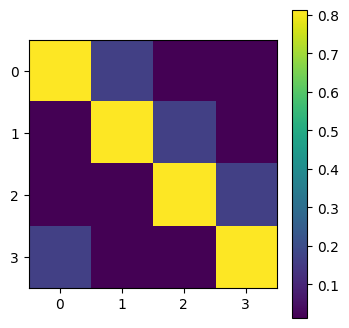

In [44]:
plt.figure(figsize=(4,4))
plt.imshow(transition_matrix)
plt.colorbar()
plt.xticks(np.arange(true_num_states))
plt.yticks(np.arange(true_num_states))

# Generate simulated data with our HMM

<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Our model here is defined entirely by the parameters in the last cell. We can use this model to simulate data to get us started!

</div>

In [55]:
# HMMS are stochastic. 
#This means that, for reproducibility, we need to seed our random number generator 
# This line seeds the JAX random generator in a way that the HMM will be happy with!
key = jr.PRNGKey(0)

In [71]:
# Simulate 100 samples from our HMM
num_timesteps = 100
true_states, true_observations = hmm.sample(key=key, params=true_params, num_timesteps=num_timesteps)
true_states

Array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 3, 3, 3, 0,
       0, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2], dtype=int32)

In [72]:
true_observations[:5]

Array([[ 0.38938606, -0.50892013],
       [ 0.99112475,  0.0206391 ],
       [ 0.98933303,  0.10901134],
       [ 1.0500388 , -0.1334458 ],
       [ 1.1099365 ,  0.30537152]], dtype=float32)

<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Great! We have some data! Let try plotting it.
</div>

In [73]:
# Helper functions for plotting
def plot_gaussian_hmm(hmm, params, emissions, states,  title="Emission Distributions", alpha=0.25):
    """
    Visualize a 2D Gaussian HMM by plotting emission distributions and observed data trajectories.
    
    Creates a comprehensive plot showing:
    - Contour plots of each state's Gaussian emission distribution
    - Observed data points colored by their true hidden state
    - Connected trajectory path showing temporal sequence
    
    Parameters
    ----------
    hmm : GaussianHMM
        A fitted Gaussian Hidden Markov Model from dynamax with 2D emissions.
    params : dict or NamedTuple
        HMM parameters containing emission means, covariances, and transition matrices.
        Typically obtained from hmm.initialize() or hmm.fit().
    emissions : array_like, shape (T, 2)
        Sequence of 2D observations/emissions over time T.
    states : array_like, shape (T,)
        True hidden state sequence corresponding to each emission.
        Values should be integers in range [0, hmm.num_states).
    title : str, optional
        Plot title. Default is "Emission Distributions".
    alpha : float, optional
        Transparency level for data points and trajectory line (0-1). Default is 0.25.
        
    Returns
    -------
    None
        Displays the plot using matplotlib.
    """
    lim = 1.1 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    plt.figure()
    for k in range(hmm.num_states):
        lls = hmm.emission_distribution(params, k).log_prob(grid)
        plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape), cmap=white_to_color_cmap(COLORS[k]))
        plt.plot(emissions[states == k, 0], emissions[states == k, 1], "o", mfc=COLORS[k], mec="none", ms=5, alpha=alpha)

    plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=alpha)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title(title)
    plt.gca().set_aspect(1.0)
    plt.tight_layout()

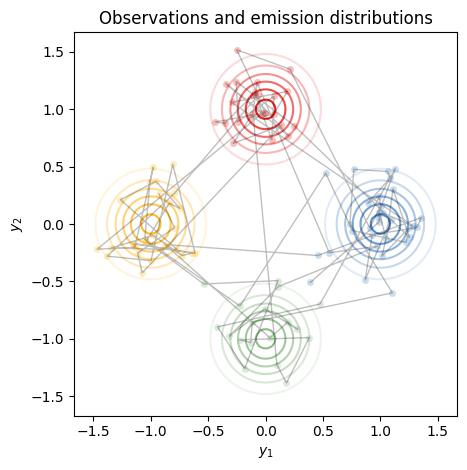

In [76]:
# Visualize emission distributions, observation sequence, and true_states 
plot_gaussian_hmm(hmm, true_params, true_emissions, true_states, 
                  title="Observations and emission distributions")

In [77]:
def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None, title = "Simulated data from an HMM"):
    """
    Create a time-series visualization of HMM emissions with hidden state background.
    
    Generates a multi-panel plot showing how observed emissions evolve over time,
    with background colors indicating the active hidden state at each time step.
    Each emission dimension gets its own subplot with observed data, expected means,
    and color-coded state information.
    
    Parameters
    ----------
    hmm : GaussianHMM
        A Gaussian Hidden Markov Model from dynamax.
    params : dict or NamedTuple
        HMM parameters containing emission means and other model parameters.
        Must include params.emissions.means with shape (num_states, emission_dim).
    emissions : array_like, shape (T, D)
        Sequence of D-dimensional observations over T time steps.
    states : array_like, shape (T,)
        Hidden state sequence corresponding to each time step.
        Values should be integers in range [0, hmm.num_states).
    xlim : tuple of (float, float), optional
        Time axis limits as (start, end). If None, uses full data range (0, T).
    title : str, optional
        Main plot title. Default is "Simulated data from an HMM".
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the plot.
    axs : array of matplotlib.axes.Axes
        Array of subplot axes, one per emission dimension.
    """
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True, figsize = (15, 5))
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title(title)
    plt.tight_layout()

    return fig, axs

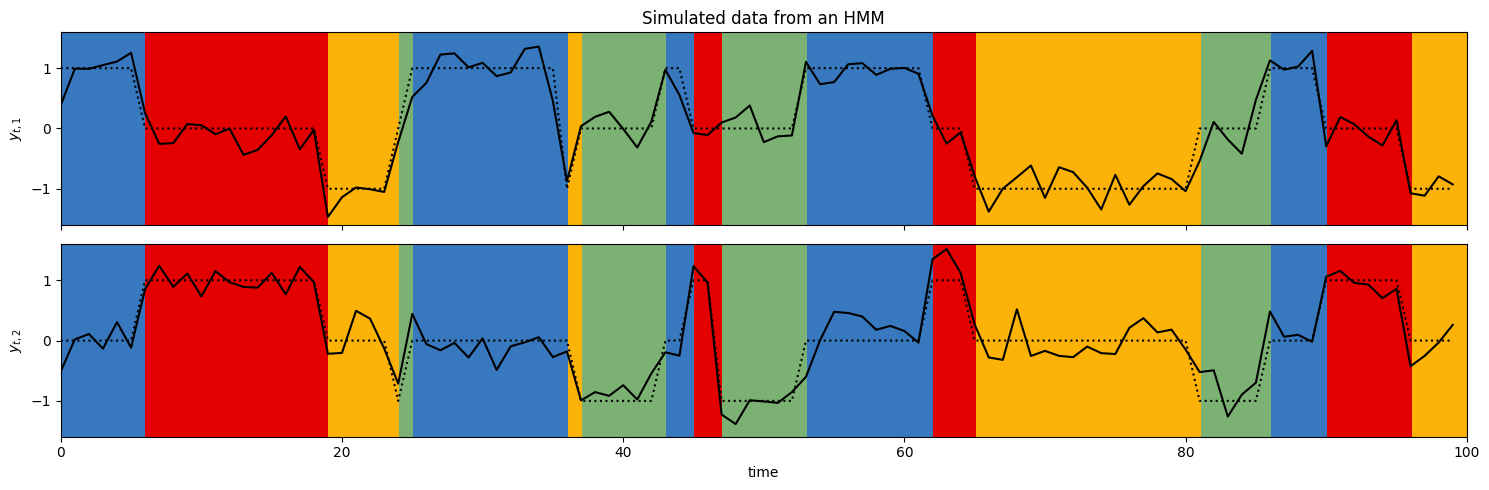

In [79]:
plot_gaussian_hmm_data(hmm, true_params, true_observations, true_states);

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 2.4: </b> How does the HMM data change as you alter the transition matrix? Also, try changing the number of hidden states. 
</div>

In [99]:
"""
Starter code for you to change these parameters for task 2.4
"""

# Make an HMM and sample data and true underlying states
# CHANGE THESE!!!!!!!!!!!
true_num_states_2 = 3
observations_dim_2 = 2
hmm_2 = GaussianHMM(true_num_states_2, observations_dim_2)

# Use Jax to make a transition matrix.
# CHANGE THESE TOO!!!!!!!
transition_matrix_2 = 0.1 * jnp.eye(true_num_states_2) \
    + 0.9 * jnp.roll(jnp.eye(true_num_states_2), 1, axis=1) \
    + 0. / true_num_states_2

# Use Jax to set the the emission probabilities - mean and covariances
emission_means_2 = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states_2 + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states_2 + 1))[:-1],
    jnp.zeros((true_num_states_2, observations_dim_2 - 2)),
    ])
emission_covs_2 = jnp.tile(0.25**2 * jnp.eye(observations_dim), (true_num_states, 1, 1))

# Set the initial state distribution - change this to unequal probabilities.
initial_probs_2 = jnp.ones(true_num_states_2) / true_num_states_2

# Construct the HMM - this will be our ground truth 
true_params_2, _ = hmm_2.initialize(initial_probs=initial_probs_2,
                                transition_matrix=transition_matrix_2,
                                emission_means=emission_means_2,
                                emission_covariances=emission_covs_2)

# Sample your altered HMM
num_timesteps_2 = 100
key_2 = jr.split(jr.PRNGKey(0), 1)[0]
true_states_2, observations_2 = hmm_2.sample(key = key_2, params=true_params_2, num_timesteps=num_timesteps_2)

(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Simulated data from an HMM'}, ylabel='$y_{t,1 }$'>,
        <Axes: xlabel='time', ylabel='$y_{t,2 }$'>], dtype=object))

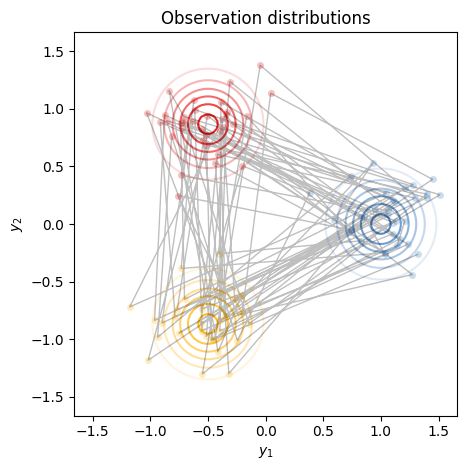

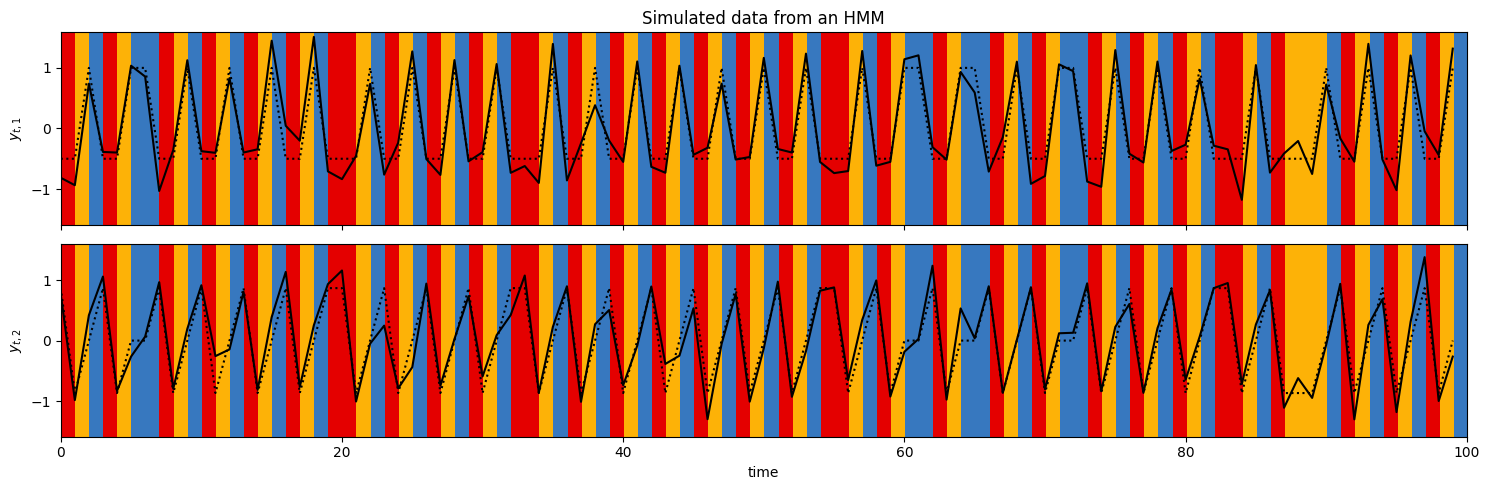

In [100]:
# Plot emissions and true_states for Task 2.4
plot_gaussian_hmm(hmm_2, true_params_2, observations_2, true_states_2, 
                  title="Observation distributions")

plot_gaussian_hmm_data(hmm_2, true_params_2, observations_2, true_states_2)


<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

So far, we have seen what the different parameters of our HMM do. 

But most of the time, we don't actually have the luxury of knowing our model parameters when we start--we need to recover them from our data.

</div>

In [37]:
# Random key
key = jr.PRNGKey(0)

# Instatiate a model.
# Lets start by assuming we know the number of states
model = GaussianHMM(true_num_states, observations_dim,) 

# Initialize the model using the observations from our "ground truth"
params, props = model.initialize(key=key, method='kmeans', emissions=true_observations)

fit_params, train_lps = model.fit_em(params, props, true_observations, 
                                             num_iters=100, verbose=False)

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Where the LinearSVM has a "score" function, we can use the marginal log probability to achieve a similar goodness of fit metric. 

</div>

In [38]:
model.marginal_log_prob(fit_params, true_observations)

Array(-45.13968, dtype=float32)

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Does this number mean anything to you? It won't yet, but we will come back to make sense of it shortly...

First, though, lets looks at some a more interpretable model parameter.
</div>

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 2.5:
Here, <i>fit_params</i> includes the "best fit" parameters of the model. Using <i> fit_params.transitions.transition_matrix</i> will EM fit transition matrix for this model. Try plotting it. Does it look like you would expect?

</div>

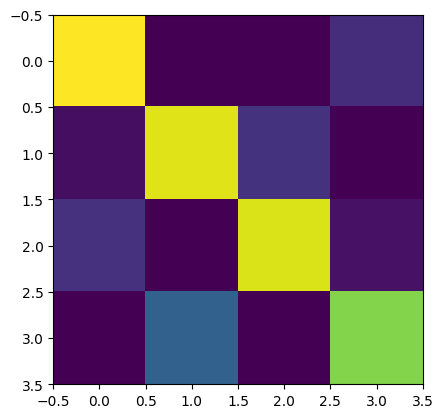

In [39]:
plt.imshow(fit_params.transitions.transition_matrix)

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> Reconstructing the transition matrix for a know model is, perhapse, to easy a problem. In most cases we won't have anywhere near this much prior information the underlying HMM we are trying to reconstruct. What is, for example, the true number of states in mouse? Yeah, I don't know either.
    
</div>


<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> In previous days, we've seen the vitial importance of cross-validation as a saneity check on your data to avoid overfitting. Let's bring those principles in here.

<p> To make this work, lets go ahead and simulate three "chunks" of data from our ground truth model. In "real life," you will do this by splitting your data up. Here, we have the artificial luxury of simulating seperate chunks. 

</div>


In [40]:
# Separating data into batches
num_train_batches = 3
num_timesteps= 100

# Simulate 3 sets of data from the mode
train_key = jr.split(jr.PRNGKey(0), 3)
train_true_states = np.zeros((num_train_batches, num_timesteps)).astype(int)
train_observations = np.zeros((num_train_batches, num_timesteps,  observations_dim))
for k in range(num_train_batches):
    train_true_states[k], train_observations[k] = hmm.sample(key = train_key[k], params=true_params, num_timesteps=num_timesteps)

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Here are some functions that "splits" above to fit evaluate models.
    
</div>

In [41]:
from copy import deepcopy

def fit_model_fold(model, params, props, y_train, y_val, num_iters=100):
    # Fit on the training batches, evaluate on the held-out batch
    fit_params, train_lps = model.fit_em(params, props, y_train,
                                         inputs=None, num_iters=num_iters, verbose=False)
    return model.marginal_log_prob(fit_params, y_val)

def cross_validate_model(model, key, train_observations, num_iters=100,):
    """
    train_observations: array with shape (num_batches, T, D) (or (num_batches, ...))
    """
    num_train_batches = int(train_observations.shape[0])

    val_lls = np.zeros(num_train_batches, dtype=float)

    out_models = [None]*num_train_batches

    for k in range(num_train_batches):
        # held-out validation batch
        y_val = train_observations[k]
        # all other batches concatenated along batch axis
        y_train = jnp.concatenate([train_observations[:k], train_observations[k+1:]], axis=0)

        # Each fold gets a radom key
        k_key = jr.fold_in(key, k)
        # Make the model for this fold
        this_model = deepcopy(model)
        params, props = this_model.initialize(key=k_key, method='kmeans', emissions=y_train)
        
        val_lls[k] = float(fit_model_fold(this_model, params, props, y_train, y_val, num_iters))

        out_models[k] = this_model
        
    return float(val_lls.mean()), val_lls, out_models



<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Now lets cross validate!
    
</div>

In [101]:
# An example for 
this_num_states = 4
observation_dims = 2
cv_model  = GaussianHMM(this_num_states, observation_dims, transition_matrix_stickiness=10.) 
cv_key = jr.PRNGKey(0)
mean_ll,fold_lls,mdls = cross_validate_model(cv_model,cv_key,train_observations)
print(mean_ll)
print(fold_lls)

-80.57849629720052
[-65.66812134 -97.47227478 -78.59509277]


<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> On its own, this log likelihood data isn't super useful. Log likelihood, for example, scales with the number of samples, so its tricky to compare accross datasets.

<p> Where it can be useful, however, is in comparing models that are fit on the same data. 

<p> Lets go ahead and try this. We will fit models with different states, then use the log likelihoods to evalue which model is "best."</p>


</div>

In [ ]:
# Make a range of Gaussian HMMs
all_num_states = list(range(2, 10))

avg_val_lls = np.zeros(len(all_num_states))
all_val_lls = np.zeros((len(all_num_states),3))

for ii,this_num_states  in enumerate(all_num_states):
    print(f"fitting model with {this_num_states} states")
    this_model = GaussianHMM(this_num_states, observation_dims, transition_matrix_stickiness=10.) 
    mean_ll,fold_lls = cross_validate_model(this_model,cv_key,train_observations)
    avg_val_lls[ii] = mean_ll
    all_val_lls[ii,:] = fold_lls


fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states
fitting model with 7 states
fitting model with 8 states
fitting model with 9 states


<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Lets plot up the average validation log-likelihood and discuss with your neighbor the implications of this curve shape? If you didn't know how many true states there where, how would you decide when to stop adding states? Will this lesson generalize to other types of data?
</div>

In [ ]:
plt.figure(figsize = (4, 3))
for cv in range(num_train_batches):
    plt.plot(all_num_states, np.array(all_val_lls)[:, cv], '.-', label = f'fold {cv}')
plt.legend()
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")
plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> How should we choose the right number of states? 
    
<p> There's no single "right" answer for how to choose the number of states, but reasonable heuristics include:
    
<ul> * picking $K$ that has the highest average validation log prob
<p> * picking $K$ where the average validation log prob stops increasing by a minimum amount
<p> * picking $K$ with a hypothesis test for increasing mean
<p> * picking $K$ consistent with the predicability-computability-stability (PCS) framework.
    
<p> Here, we'll just choose the number of states with the highest average.
</div>


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 1.7: </b> Use the average log likelihood from the cross validation to determine the best number of states for our HMM. Save it as a variable called "best_num_states." Did we do a good job of recapitulating our ground truth?

<p> Note that this is "OK" because our folds are all the same size, so this falls into the special case where log likelihoods are safe to compare!</p>
</div>

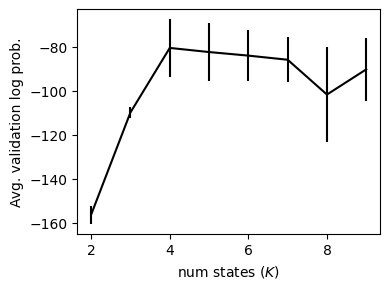

In [142]:
# Blank coding cell to work out Task 2.1

plt.figure(figsize = (4, 3))
std_dev= np.nanstd(all_val_lls, axis= 1)
plt.errorbar(all_num_states, avg_val_lls, yerr = std_dev , color='k')
plt.xlabel("num states ($K$)")
plt.ylabel("Avg. validation log prob.")
plt.tight_layout()

In [143]:
best_num_states = all_num_states[jnp.argmax(jnp.stack(avg_val_lls))]
print("best number of states:", best_num_states)

best number of states: 4


<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now that we have a guess as to the "best" number of parameters, we can find the most likely state any any given instance in time.

In [150]:
# Fit the model
key = jr.PRNGKey(0)
test_hmm = GaussianHMM(best_num_states, observations_dim, transition_matrix_stickiness=10.)
params, props = test_hmm.initialize(key=key, method="kmeans", emissions=true_observations)
params, lps = test_hmm.fit_em(params, props, train_observations, num_iters=100)

In [148]:
# Predict states.
most_likely_states = test_hmm.most_likely_states(params, true_observations)


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">

<p><b>Task 1.7: </b> Use the plot_gaussian_hmm_data to plot the True states and estimated reconstruction. What do you notice.

</div>

(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Estimated states'}, ylabel='$y_{t,1 }$'>,
        <Axes: xlabel='time', ylabel='$y_{t,2 }$'>], dtype=object))

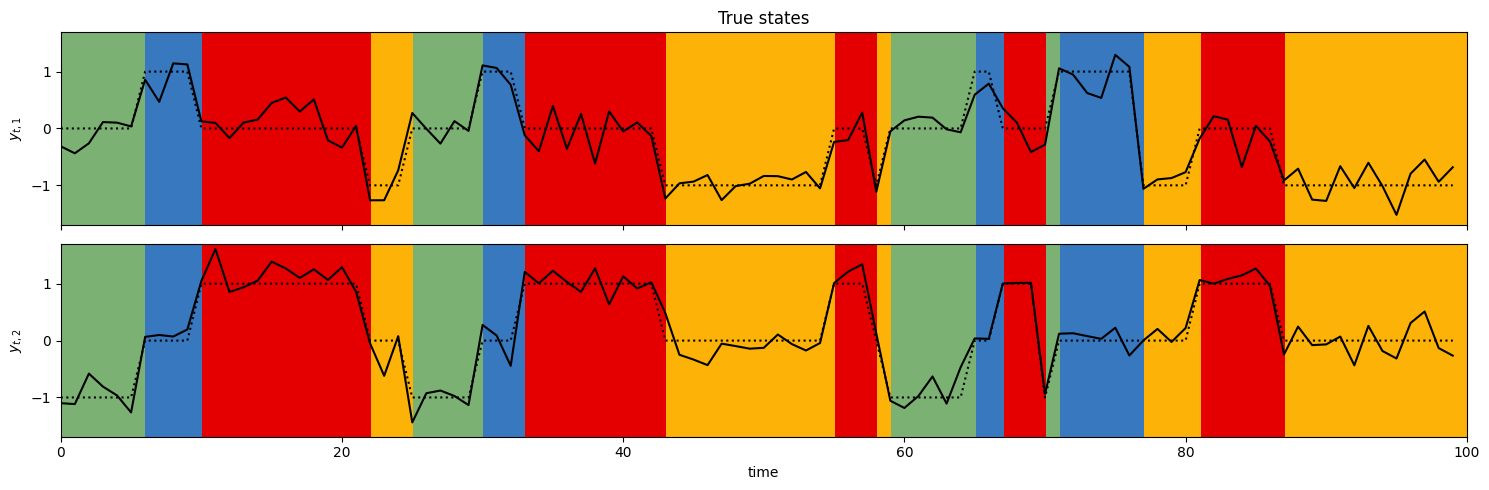

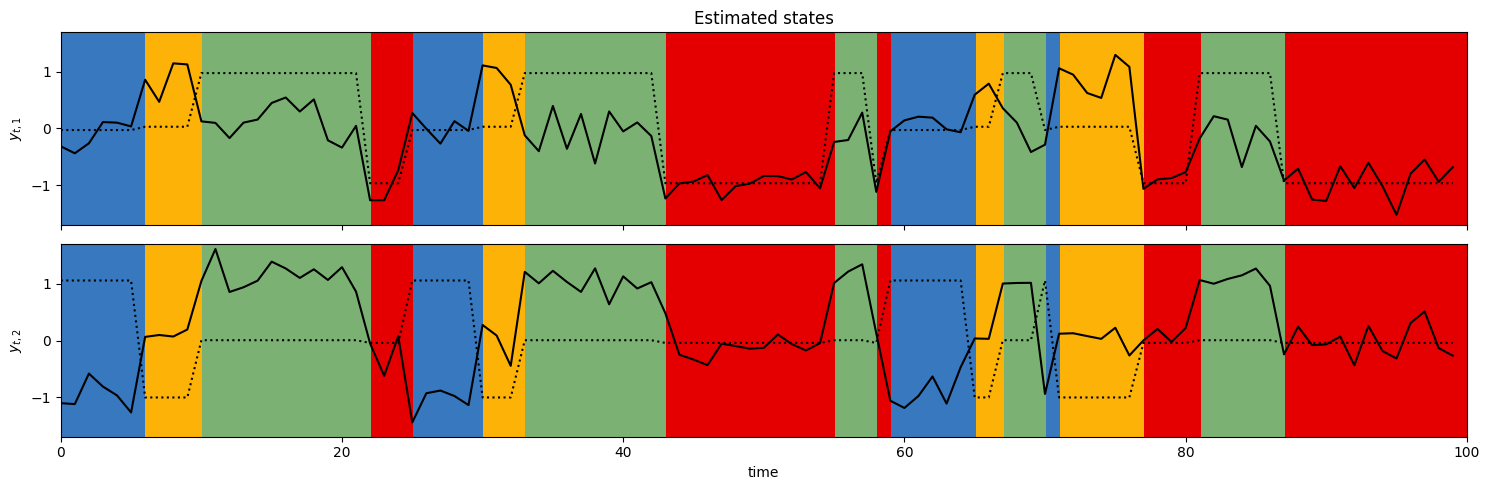

In [154]:
# helper code for task 1.9

plot_gaussian_hmm_data(hmm, true_params, true_observations, true_states, title = 'True states')

# Get inferred states

plot_gaussian_hmm_data(test_hmm, params, true_observations, most_likely_states, title = 'Estimated states')


# State determination in Visual Behavior Neuropixels data

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> We now kind of get a hang of HMM. So, let's take what we've done above and apply it to the behavior variables from the previous workshop to automatically detect states in our mice! Now, we have the capability to incorporate a multi-dimensional dataset to inform our state boundaries. 
<p> To accomplish this goal, we will fit our data to a Gaussian HMM. 
    
<p> To complement our states from the previous workshop, lets extract the behavior states using only behavior data, that is, pupil size, running speed and lick counts.
</div>

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Our first step will be to cast our data as <b>JAX</b> arrays

In [101]:
# For this model, it's important that the data is converted into a *JAX* array
observations = jnp.array(behavior_df.values)
num_trials, num_dimensions = observations.shape

In [102]:
behavior_df.head(5)

,running_speed,pupil_area,lick_count
id,,,
13,36.486412,4292.583735,19
15,33.135666,4041.700482,18
17,35.149516,4049.560114,16
18,53.751427,4039.805348,14
22,38.937263,4220.875109,18


In [103]:
observations[:5,:]

Array([[  36.486412, 4292.5835  ,   19.      ],
       [  33.135666, 4041.7004  ,   18.      ],
       [  35.149517, 4049.56    ,   16.      ],
       [  53.751427, 4039.8054  ,   14.      ],
       [  38.937263, 4220.875   ,   18.      ]], dtype=float32)

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
You will notice that all of these data are in very different values. Remember the <b>StandardScaler</b> from this AM? It can help us deal with these very differently scaled data by Z-scoring them.

In [104]:
# First scale the dimensions of the data to be normalized
scaler = StandardScaler()    
observations = scaler.fit_transform(observations)
observations[:5,:]

array([[-1.1954191 , -1.4065826 ,  1.7025528 ],
       [-1.4537793 , -1.6804162 ,  1.5650946 ],
       [-1.2985008 , -1.6718376 ,  1.2901782 ],
       [ 0.13580525, -1.6824845 ,  1.0152617 ],
       [-1.0064454 , -1.4848509 ,  1.5650946 ]], dtype=float32)

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Finally, lets parameterize our cross validation.

In [48]:
# Finally, lets parameterize our cross validiation
n_batches = 6
n_steps = num_trials - (num_trials % n_batches)
batched_observations = observations[:n_steps, :].reshape(n_batches, -1, observations.shape[1])
batch_size = batched_observations.shape[1]

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
One very quick mathematical aside: <b>Dynamax</b> can't handle num_states = 1 (a simple way of thinking about this is that a one state model isn't really a mixture, is it?). But what if our mouse is in the same state the whole time?

The good news is that is is pretty straightforward to use a maximum likelyhood estimator to compute the log likelihood for a single gaussian fit to the data. Here is a function that uses <b>JAX</b> to do this. 

In [49]:
from jax.scipy.stats import multivariate_normal as mvn

def _gaussian_mle_loglik(y_train, y_val, eps=1e-6):
    """
    y_train: (B_train, T, D) or (N, D)
    y_val:   (T, D) or (B_val, T, D) -> we’ll handle both
    """
    # Flatten batch/time for MLE
    Yt = jnp.reshape(y_train, (-1, y_train.shape[-1]))  # (N_train, D)
    mu = jnp.mean(Yt, axis=0)                           # (D,)
    # Unbiased sample cov; regularize for numeric stability
    Yc = Yt - mu
    # (D,D)
    Sigma = (Yc.T @ Yc) / jnp.maximum(Yt.shape[0] - 1, 1)
    Sigma = Sigma + eps * jnp.eye(Sigma.shape[0], dtype=Sigma.dtype)

    # Evaluate log-likelihood on validation
    if y_val.ndim == 3:  # (B_val, T, D)
        Yv = jnp.reshape(y_val, (-1, y_val.shape[-1]))
    else:                # (T, D)
        Yv = y_val
    ll = jnp.sum(mvn.logpdf(Yv, mu, Sigma))
    return float(ll)


<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
We now need to update our cross validation code to handle this new case.

In [51]:
def fit_model_fold(model, params, props, y_train, y_val, num_iters=100):
    fit_params, train_lps = model.fit_em(params, props, y_train,
                                         inputs=None, num_iters=num_iters, verbose=False)
    return model.marginal_log_prob(fit_params, y_val)

def cross_validate_model(model, key, train_observations, num_iters=100):
    """
    train_observations: array with shape (num_batches, T, D) (or (num_batches, ...))
    """
    num_train_batches = int(train_observations.shape[0])
    val_lls = np.zeros(num_train_batches, dtype=float)
    out_models = [None]*num_train_batches

    for k in range(num_train_batches):
        y_val = train_observations[k]
        y_train = jnp.concatenate([train_observations[:k], train_observations[k+1:]], axis=0)

        if model.num_states == 1:
            # Bypass Dynamax EM/prior for 1-state; use Gaussian MLE baseline.
            val_lls[k] = _gaussian_mle_loglik(y_train, y_val)
            out_models[k] = None  # or store (mu, Sigma) if you like
            continue

        # K >= 2: normal Dynamax path
        k_key = jr.fold_in(key, k)
        this_model = deepcopy(model)
        params, props = this_model.initialize(key=k_key, method='kmeans', emissions=y_train)
        val_lls[k] = float(fit_model_fold(this_model, params, props, y_train, y_val, num_iters))
        out_models[k] = this_model

    return float(val_lls.mean()), val_lls, out_models

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Great! We are now ready for the "Main Event;" some model fitting with <b>real</b> data.

In [52]:
# Random key so things dont change each time we run the cell
key = jr.PRNGKey(0)

# Number of states to test
num_states_range = np.arange(1, 9)


# Define empty lists so that we have place to put our data.
avg_test_lls = np.empty(len(num_states_range))
all_test_lls = np.empty([len(num_states_range),n_batches])
std_test_lls = np.empty(len(num_states_range))
#similarity_of_states_across_batches = np.empty(len(num_states_range))



for ii,num_states in enumerate(num_states_range):
    hmm = GaussianHMM(num_states, batched_observations.shape[-1], transition_matrix_stickiness=10.)
    
    print(f"\n{'='*40}\nTraining model with {num_states} state(s)\n{'='*40}")
    
    avg_ll, lls, fold_models = cross_validate_model(
        hmm, key, batched_observations, num_iters=100
    )
    avg_test_lls[ii] = avg_ll
    all_test_lls[ii,:] = lls.flatten()
    std_test_lls[ii] = np.std(all_test_lls[ii,:])


    


Training model with 1 state(s)

Training model with 2 state(s)

Training model with 3 state(s)

Training model with 4 state(s)

Training model with 5 state(s)

Training model with 6 state(s)

Training model with 7 state(s)

Training model with 8 state(s)


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">

<p><b>Task 1.7: </b> Plot the Log Likeihoods from these data. What is our best number of states? 

Go Ahead and fit a full model using this optimized state distinction, and use the privided code to the state classifications of this model over the full session.
</div>

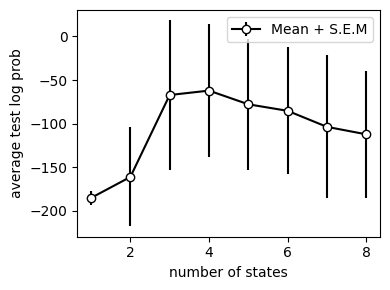

In [68]:
plt.figure(figsize = (4, 3))
plt.errorbar(num_states_range, avg_test_lls, yerr = np.array(std_test_lls)/np.sqrt(n_batches), mfc = 'w', color = 'k', marker = 'o')

plt.legend(['Mean + S.E.M'])
plt.xlabel("number of states")
plt.ylabel("average test log prob")
plt.tight_layout()

In [69]:
key = jr.PRNGKey(0)
number_of_states = 4
final_hmm = GaussianHMM(number_of_states, num_dimensions, transition_matrix_stickiness=1)
params, param_props = final_hmm.initialize(key=key, method="kmeans", emissions=jnp.array(observations))
params, lps = final_hmm.fit_em(params, param_props, jnp.array(observations), num_iters=500)


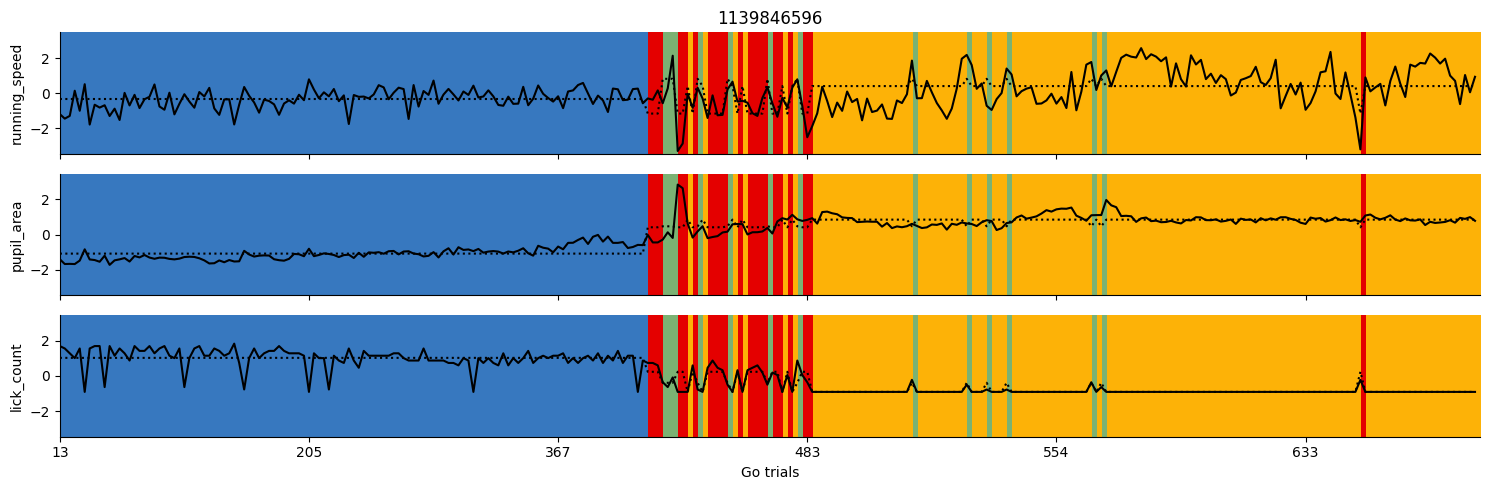

In [70]:
def minmax(x):
    # Function to normalize the data for easy visualization
    return (x - np.min(x))/(np.max(x) - np.min(x)) 


def get_state_intervals(x, state_seq, target_state):
    # Find contiguous intervals where state_seq == target_state
    intervals = []
    in_interval = False
    for i in range(len(state_seq)):
        if state_seq[i] == target_state and not in_interval:
            start = x[i]
            in_interval = True
        elif state_seq[i] != target_state and in_interval:
            end = x[i]
            intervals.append((start, end))
            in_interval = False
    if in_interval:
        intervals.append((start, x[-1]))
    return intervals


# Find the most likely discrete states given the learned model parameters
most_likely_states = final_hmm.most_likely_states(params, observations)
fig, axs = plot_gaussian_hmm_data(final_hmm, params, observations, most_likely_states, title = f'{session_id}')

# Formatting 
xticks = axs[0].get_xticks().astype(int)[:-1]
for n, ax in enumerate(axs):
    ax.set_xticks(xticks)
    ax.set_xticklabels(go_trials.index.values[xticks])
    ax.set_ylabel(f'{behavior_df.keys()[n]}')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
axs[-1].set_xlabel('Go trials')
plt.tight_layout()

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">

<p><b>Task 1.7: </b> One way to summerize the relationship between states and the underlying behavior is to look at the emission means for each state.

The cose below will plot this for you.

Take a momemt to think about what this plot tells you.

</div>

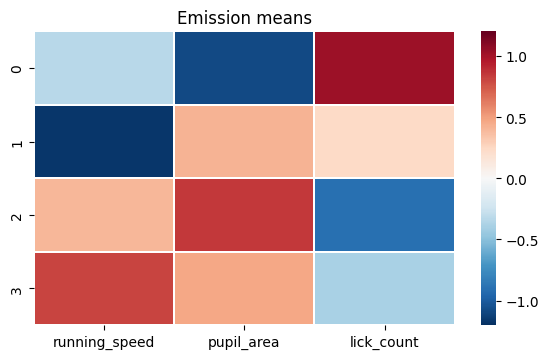

In [71]:
plt.figure(figsize = (5.8, 3.7))
sns.heatmap(params.emissions.means, xticklabels = behavior_df.keys(), yticklabels= np.arange(number_of_states), cmap = 'RdBu_r', linewidths=0.2, vmax = 1.2, vmin = -1.2)
plt.title('Emission means')
plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Finally, lets bring this full circle. Lets plot the result of our model relative to our the thresholding method we used at the beginning of this tutorial. Did we uncover anything new?

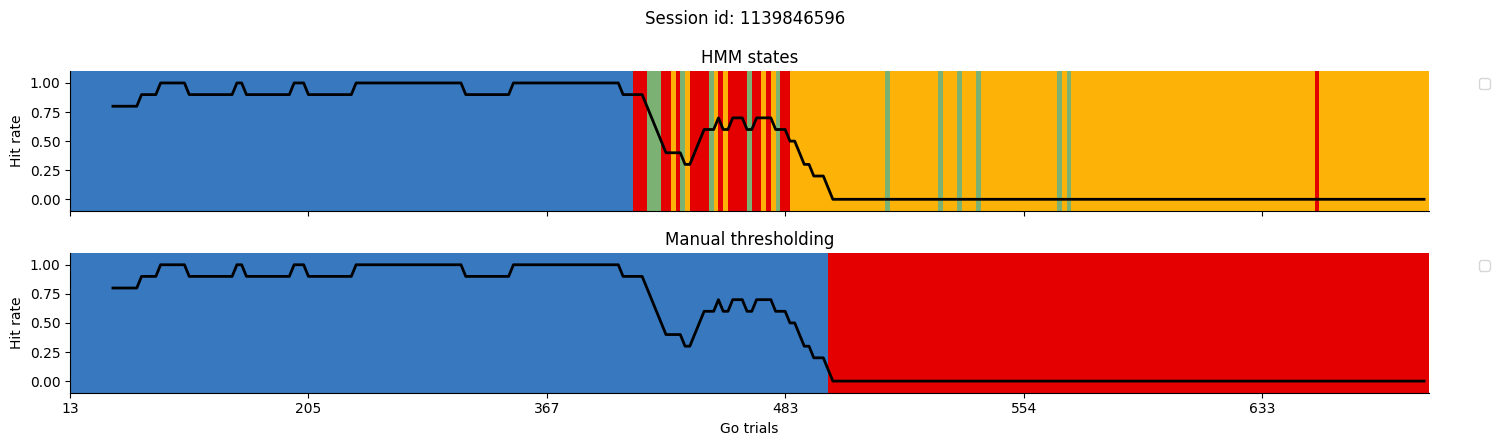

In [74]:
# Define state boundaries 
fig, ax = plt.subplots(2, 1, figsize=(15, 4.5), sharex=True)
hmm_states = most_likely_states
ax[0].imshow(hmm_states[None, :], aspect="auto", interpolation="none", cmap=CMAP, vmin=0, vmax=len(COLORS) - 1,  extent=[0, len(hmm_states), -0.1, 1.1]  )
ax[0].plot(hit_rate.values, color = 'k', lw = 2)

# from previous definition

ax[1].imshow(states.values[None, :], aspect="auto", interpolation="none", cmap=CMAP, vmin=0, vmax=len(COLORS) - 1,  extent=[0, len(states), -0.1, 1.1]  )
# for state_id in range(np.nanmax(states)+1): 
#     ax[1].fill_between(go_trials.index, 0, 1, where = states == state_id, alpha=0.5, color = cmap[state_id], ls = 'None', label = f'state {state_id}')
ax[1].plot(hit_rate.values, color = 'k', lw = 2)

# Formatting 
ax[0].set_title('HMM states')
ax[1].set_title('Manual thresholding')
ax[1].set_xlabel("Go trials")

xticks = ax[0].get_xticks().astype(int)[:-1]
for j in range(2): 
    ax[j].set_ylabel('Hit rate')
    ax[j].set_xticks(xticks)
    ax[j].set_xticklabels(go_trials.index.values[xticks])
    handles, labels = ax[j].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax[j].legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.05, 1), fontsize = 10)

    ax[j].spines["top"].set_visible(False)
    ax[j].spines["right"].set_visible(False)

plt.suptitle(f'Session id: {session_id}')
plt.tight_layout()

In [ ]:
<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
This brings us to the end of this session. In the homework you will get a change to dive into these state deffinitions a little more carfully. Specifficaly, you will get a chance to st

In [73]:

# Define empty lists that we'll populate below
avg_test_log_probs = []
all_test_log_probs = []
std_test_log_probs = []
similarity_of_states_across_batches = []

key = jr.PRNGKey(0)
num_states_range = np.arange(1, 9)
# Run a loop to fit the data to a range of states
for num_states in num_states_range:
    print(f"\n{'='*40}\nTraining model with {num_states} state(s)\n{'='*40}")

    test_log_probs = []
    
    predicted_states = np.zeros([num_trials, n_batches], dtype = int)
    
    for batch in range(n_batches):
        # Extract all but this batch for training
        train_observations = np.concatenate([batched_observations[:batch], batched_observations[batch+1:]])#.reshape((n_batches - 1)*batch_size, -1)
        flat_train_observations = train_observations.reshape((n_batches - 1) * batch_size, -1)
        if num_states == 1:
            train_mean = jnp.mean(flat_train_observations, axis=0).reshape([1,num_dimensions])
            train_cov = jnp.cov(flat_train_observations.T)
            test_data = jnp.array(batched_observations[batch])    #scaler.transform(jnp.array(batched_observations[batch]))
            test_lp = tfd.MultivariateNormalFullCovariance(train_mean, train_cov).log_prob(batched_observations[batch]).sum()
        else:
            # Make an HMM
            hmm = GaussianHMM(num_states, num_dimensions, transition_matrix_stickiness=10.)
            params, param_props = hmm.initialize(key=key, method="kmeans", emissions=jnp.array(train_observations))

            # Fit the model
            params, lps = hmm.fit_em(params, param_props, jnp.array(train_observations), num_iters=500)
            
            #extract predicted states
            predicted_states[:,batch] = hmm.most_likely_states(params, observations)

            # Evaluate the log probability on held out data
            test_lp = hmm.marginal_log_prob(params, jnp.array(batched_observations[batch]))
        test_log_probs.append(test_lp)

    # Calculate the similarity of each set of predicted states
    if batch != 1:
        distance_between_batches = []
        for i in range(n_batches):
            for j in range(i-1):
                bestpermutation = find_permutation(predicted_states[:,i], predicted_states[:,j])
                distance_between_batches.append(np.sum(jnp.take(bestpermutation, predicted_states[:,i]) == predicted_states[:,j])/observations.shape[0])
        similarity_of_states_across_batches.append(np.mean(distance_between_batches))
    else:
        similarity_of_states_across_batches.append(1)
        
    # Store the average test log prob
    all_test_log_probs.append(test_log_probs)
    avg_test_log_probs.append(np.nanmean(test_log_probs))
    std_test_log_probs.append(np.nanstd(test_log_probs))    


Training model with 1 state(s)

Training model with 2 state(s)



Training model with 3 state(s)



Training model with 4 state(s)



Training model with 5 state(s)



Training model with 6 state(s)



Training model with 7 state(s)



Training model with 8 state(s)


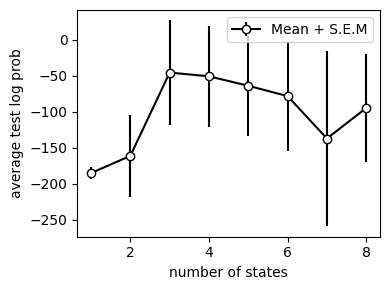

In [74]:
plt.figure(figsize = (4, 3))
plt.errorbar(num_states_range, avg_test_log_probs, yerr = np.array(std_test_log_probs)/np.sqrt(n_batches), mfc = 'w', color = 'k', marker = 'o')

# If you like, you can plot up each of the log_probs from the session.
#for k, test_log_probs in zip(num_states_range, all_test_log_probs):
#    plt.plot(k * np.ones(n_batches), test_log_probs, 'r.')

plt.legend(['Mean + S.E.M'])
plt.xlabel("number of states")
plt.ylabel("average test log prob")
plt.tight_layout()

In [75]:
key = jr.PRNGKey(0)
best_num_states = 3
number_of_states = best_num_states 
final_hmm = GaussianHMM(number_of_states, num_dimensions, transition_matrix_stickiness=1)
params, param_props = final_hmm.initialize(key=key, method="kmeans", emissions=jnp.array(observations))
params, lps = final_hmm.fit_em(params, param_props, jnp.array(observations), num_iters=500)


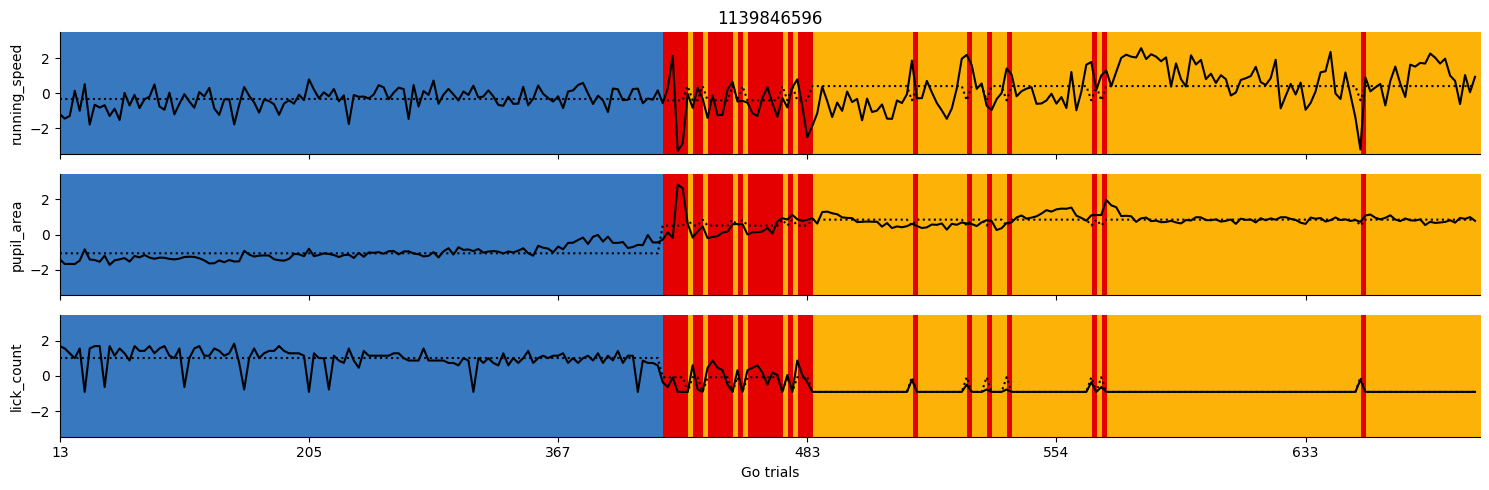

In [76]:
def minmax(x):
    # Function to normalize the data for easy visualization
    return (x - np.min(x))/(np.max(x) - np.min(x)) 


def get_state_intervals(x, state_seq, target_state):
    # Find contiguous intervals where state_seq == target_state
    intervals = []
    in_interval = False
    for i in range(len(state_seq)):
        if state_seq[i] == target_state and not in_interval:
            start = x[i]
            in_interval = True
        elif state_seq[i] != target_state and in_interval:
            end = x[i]
            intervals.append((start, end))
            in_interval = False
    if in_interval:
        intervals.append((start, x[-1]))
    return intervals


# Find the most likely discrete states given the learned model parameters
most_likely_states = final_hmm.most_likely_states(params, observations)
fig, axs = plot_gaussian_hmm_data(final_hmm, params, observations, most_likely_states, title = f'{session_id}')

# Formatting 
xticks = axs[0].get_xticks().astype(int)[:-1]
for n, ax in enumerate(axs):
    ax.set_xticks(xticks)
    ax.set_xticklabels(go_trials.index.values[xticks])
    ax.set_ylabel(f'{behavior_df.keys()[n]}')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
axs[-1].set_xlabel('Go trials')
plt.tight_layout()

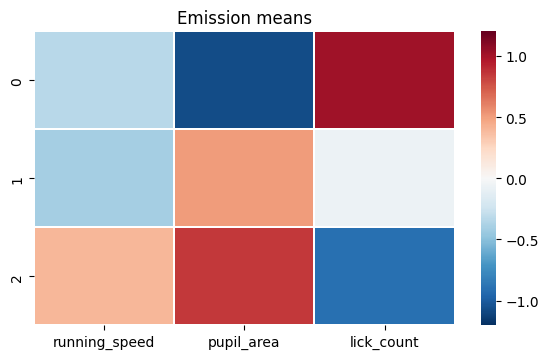

In [77]:
plt.figure(figsize = (5.8, 3.7))
sns.heatmap(params.emissions.means, xticklabels = behavior_df.keys(), yticklabels= np.arange(number_of_states), cmap = 'RdBu_r', linewidths=0.2, vmax = 1.2, vmin = -1.2)
plt.title('Emission means')
plt.tight_layout()

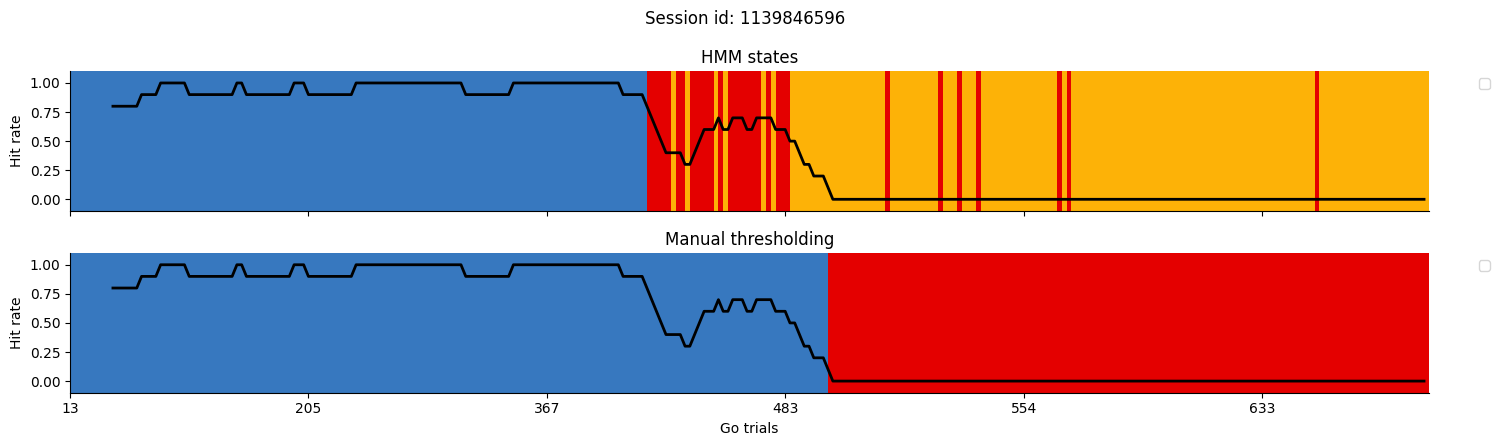

In [78]:
# Define state boundaries 
fig, ax = plt.subplots(2, 1, figsize=(15, 4.5), sharex=True)
hmm_states = most_likely_states
ax[0].imshow(hmm_states[None, :], aspect="auto", interpolation="none", cmap=CMAP, vmin=0, vmax=len(COLORS) - 1,  extent=[0, len(hmm_states), -0.1, 1.1]  )
ax[0].plot(hit_rate.values, color = 'k', lw = 2)

# from previous definition

ax[1].imshow(states.values[None, :], aspect="auto", interpolation="none", cmap=CMAP, vmin=0, vmax=len(COLORS) - 1,  extent=[0, len(states), -0.1, 1.1]  )
# for state_id in range(np.nanmax(states)+1): 
#     ax[1].fill_between(go_trials.index, 0, 1, where = states == state_id, alpha=0.5, color = cmap[state_id], ls = 'None', label = f'state {state_id}')
ax[1].plot(hit_rate.values, color = 'k', lw = 2)

# Formatting 
ax[0].set_title('HMM states')
ax[1].set_title('Manual thresholding')
ax[1].set_xlabel("Go trials")

xticks = ax[0].get_xticks().astype(int)[:-1]
for j in range(2): 
    ax[j].set_ylabel('Hit rate')
    ax[j].set_xticks(xticks)
    ax[j].set_xticklabels(go_trials.index.values[xticks])
    handles, labels = ax[j].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax[j].legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.05, 1), fontsize = 10)

    ax[j].spines["top"].set_visible(False)
    ax[j].spines["right"].set_visible(False)

plt.suptitle(f'Session id: {session_id}')
plt.tight_layout()